In [45]:
import os

import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, precision_score, recall_score

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

import copy

import time

import torch.optim as optim
#from dataset import train_dataloader, val_dataloader
#from dataset import train_dataset, val_dataset
from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import numpy as np

from sklearn.model_selection import cross_val_score

import pickle

In [2]:
main_dir = os.path.abspath('..') # os.path.join(os.getcwd())
data_dir = os.path.join(main_dir, "Data")
shapefiles_dir = os.path.join(main_dir, data_dir, "shapefiles")

In [3]:
pd.options.display.max_columns = None

In [4]:
covid_data = pd.read_csv(os.path.join(data_dir, "Merged", "covid_crime_micro_geo_11_29_2021.csv"), index_col=False)
del covid_data['date']
del covid_data[covid_data.columns[0]]
covid_data.head()

,SHIFT,OFFENSE,WARD,LATITUDE,LONGITUDE,total_cases,daily_cases,daily_death,OUT_POSITIVE_QUARANTINE_PSMPD,MO,TU,WE,TH,FR,SA,SU,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ward_1,ward_2,ward_3,ward_4,ward_5,ward_6,ward_7,ward_8,ARSON,ASSAULT W/DANGEROUS WEAPON,BURGLARY,HOMICIDE,MOTOR VEHICLE THEFT,ROBBERY,SEX ABUSE,THEFT F/AUTO,THEFT/OTHER,DAY,EVENING,MIDNIGHT,distance_metro,distance_nightclubs,distance_worship
0,EVENING,THEFT/OTHER,6.0,38.895445,-76.978994,14077.0,28.0,1.0,80.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0.189878,0.352657,0.081604
1,EVENING,ASSAULT W/DANGEROUS WEAPON,8.0,38.846282,-76.980074,14077.0,28.0,1.0,80.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0.585539,1.073603,0.156339
2,EVENING,THEFT/OTHER,4.0,38.956588,-77.012631,14077.0,28.0,1.0,80.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0.490429,0.876416,0.009941
3,EVENING,THEFT/OTHER,6.0,38.895398,-76.984577,14049.0,57.0,0.0,87.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0.229824,0.360878,0.051530
4,EVENING,THEFT F/AUTO,2.0,38.907242,-77.044167,14077.0,28.0,1.0,80.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0.063730,0.035825,0.076037


In [5]:
del covid_data["SHIFT"]
del covid_data["OFFENSE"]
del covid_data["ward_1"]
del covid_data["ward_2"]
del covid_data["ward_3"]
del covid_data["ward_4"]
del covid_data["ward_5"]
del covid_data["ward_6"]
del covid_data["ward_7"]
del covid_data["ward_8"]

covid_data['WARD'] = covid_data['WARD'].astype(int)

In [6]:
covid_data

,WARD,LATITUDE,LONGITUDE,total_cases,daily_cases,daily_death,OUT_POSITIVE_QUARANTINE_PSMPD,MO,TU,WE,TH,FR,SA,SU,JAN,FEB,MAR,APR,MAY,JUN,JUL,AUG,SEP,OCT,NOV,DEC,ARSON,ASSAULT W/DANGEROUS WEAPON,BURGLARY,HOMICIDE,MOTOR VEHICLE THEFT,ROBBERY,SEX ABUSE,THEFT F/AUTO,THEFT/OTHER,DAY,EVENING,MIDNIGHT,distance_metro,distance_nightclubs,distance_worship
0,6,38.895445,-76.978994,14077.0,28.0,1.0,80.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0.189878,0.352657,0.081604
1,8,38.846282,-76.980074,14077.0,28.0,1.0,80.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0.585539,1.073603,0.156339
2,4,38.956588,-77.012631,14077.0,28.0,1.0,80.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0.490429,0.876416,0.009941
3,6,38.895398,-76.984577,14049.0,57.0,0.0,87.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0.229824,0.360878,0.051530
4,2,38.907242,-77.044167,14077.0,28.0,1.0,80.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0.063730,0.035825,0.076037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43159,5,38.913022,-76.975955,37634.0,269.0,8.0,104.0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0.418831,0.078911,0.159204
43160,7,38.874610,-76.967094,37634.0,269.0,8.0,104.0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0.718883,0.790578,0.034208
43161,5,38.951338,-76.991691,37365.0,166.0,6.0,106.0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0.345018,0.900916,0.097899
43162,8,38.852403,-76.982313,37634.0,269.0,8.0,104.0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0.442868,0.972997,0.004663


In [7]:
del covid_data['LATITUDE']
del covid_data['LONGITUDE']

covid_data.isna().sum()

WARD                             0
total_cases                      0
daily_cases                      0
daily_death                      0
OUT_POSITIVE_QUARANTINE_PSMPD    0
MO                               0
TU                               0
WE                               0
TH                               0
FR                               0
SA                               0
SU                               0
JAN                              0
FEB                              0
MAR                              0
APR                              0
MAY                              0
JUN                              0
JUL                              0
AUG                              0
SEP                              0
OCT                              0
NOV                              0
DEC                              0
ARSON                            0
ASSAULT W/DANGEROUS WEAPON       0
BURGLARY                         0
HOMICIDE                         0
MOTOR VEHICLE THEFT 

In [8]:
# WARD, DISTRICT, total_cases, daily_cases/deaths, OUT_POSITIVE_QUARANTINE_PSMPD, DAYS (MO-SUN), SHIFT, MONTH => CRIME_CLASS (9)

In [9]:
X = covid_data.loc[:, covid_data.columns != 'WARD'].values
y = covid_data['WARD'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

In [10]:
print("X_train.shape", X_train.shape)
print("y_train.shape", y_train.shape)
print("")
print("X_test.shape", X_test.shape)
print("X_test.shape", X_test.shape)

X_train.shape (30214, 38)
y_train.shape (30214,)

X_test.shape (12950, 38)
X_test.shape (12950, 38)


# Using Standard Scaler on Data:

In [11]:
Stand_scaler = StandardScaler() # or MinMaxScaler()
Stand_scaler.fit(X_train)

X_train_Stand_scaled = Stand_scaler.transform(X_train)
X_test_Stand_scaled = Stand_scaler.transform(X_test)

print(X_train_Stand_scaled[:2])

print(X_test_Stand_scaled[:2])

[[-0.54910329 -0.32193604 -0.0669929  -1.08800173 -0.41816848 -0.41016169
  -0.40762541 -0.40008638 -0.40463935  2.42829136 -0.40513769 -0.22338135
  -0.2008864  -0.27761692 -0.2999519  -0.33575521 -0.34837168 -0.35626607
  -0.34890904 -0.37338987  3.01242287 -0.24149696 -0.23458852 -0.019933
   3.90436756 -0.22108529 -0.08815661 -0.38248313 -0.28078506 -0.08059706
  -0.65098259 -0.78110514  1.29247697 -0.88051686 -0.48246413  0.36234114
  -0.61346327 -0.29531682]
 [-1.35404294 -0.86262168 -0.16289112 -0.3993865  -0.41816848 -0.41016169
  -0.40762541 -0.40008638 -0.40463935 -0.4118122   2.46829663 -0.22338135
  -0.2008864  -0.27761692 -0.2999519  -0.33575521 -0.34837168 -0.35626607
  -0.34890904 -0.37338987  3.01242287 -0.24149696 -0.23458852 -0.019933
  -0.25612343 -0.22108529 -0.08815661  2.61449439 -0.28078506 -0.08059706
  -0.65098259 -0.78110514 -0.77370817  1.13569659 -0.48246413 -0.9562342
  -0.6200395  -0.62216534]]
[[ 1.44441154  0.27609504 -0.0669929  -0.12066129 -0.41816848 

# Using MinMax Scaler with range between 0 and 1:

In [12]:
from sklearn.preprocessing import MinMaxScaler

MinMax_scaler = MinMaxScaler(feature_range=(0, 1))

MinMax_scaler = MinMax_scaler.fit(X_train)

X_train_MinMax_scaled = MinMax_scaler.transform(X_train)
X_test_MinMax_scaled = MinMax_scaler.transform(X_test)

print(X_train_MinMax_scaled[:2])
print(X_test_MinMax_scaled[:2])

[[0.25181964 0.50302623 0.49444444 0.         0.         0.
  0.         0.         0.         1.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         1.         0.         0.         0.
  1.         0.         0.         0.         0.         0.
  0.         0.         1.         0.         0.         0.22323752
  0.03896255 0.08123364]
 [0.         0.45864156 0.49166667 0.12923077 0.         0.
  0.         0.         0.         0.         1.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         1.         0.         0.         0.
  0.         0.         0.         1.         0.         0.
  0.         0.         0.         1.         0.         0.04151332
  0.03786027 0.05212705]]
[[0.87547657 0.55211836 0.49444444 0.18153846 0.         1.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  1.         0.         0.       

# Grid Search for each:

# SVC (Support Vector Machine)

In [13]:
# with StandardScaler
curr_SVC_cls_w_StandScaler = SVC(C=41, kernel='rbf')

curr_SVC_cls_w_StandScaler.fit(X_train_Stand_scaled, y_train)
curr_y_pred_SVC_grid_with_StandScaler = curr_SVC_cls_w_StandScaler.predict(X_test_Stand_scaled)
y_true = y_test
print(f"Current C={41}")
print("    * Score is:", curr_y_pred_SVC_grid_with_StandScaler)
print("    * Accuracy:", round(accuracy_score(y_test, curr_y_pred_SVC_grid_with_StandScaler)*100, 2), "%")
print("    * Precision:", round(precision_score(y_test, curr_y_pred_SVC_grid_with_StandScaler,
                                    average='macro')*100, 2), "%")
print("    * Recall:", round(recall_score(y_test, curr_y_pred_SVC_grid_with_StandScaler,
                              average='macro')*100, 2), "%")

Current C=41
    * Score is: [7 1 6 ... 7 5 8]
    * Accuracy: 46.5 %
    * Precision: 45.13 %
    * Recall: 43.47 %


In [46]:
pickle.dump(curr_SVC_cls_w_StandScaler, open("SVC_cls_w_StandScaler_COVID.sav", 'wb'))

In [43]:
# with MinMax
curr_SVC_cls_w_MinMax = SVC(C=41, kernel='rbf')

curr_SVC_cls_w_MinMax.fit(X_train_MinMax_scaled, y_train)
curr_y_pred_SVC_grid_with_MinMax = curr_SVC_cls_w_MinMax.predict(X_test_MinMax_scaled)
y_true = y_test
print(f"Current C={41}")
print("    * Score is:", curr_y_pred_SVC_grid_with_MinMax)
print("    * Accuracy:", round(accuracy_score(y_test, curr_y_pred_SVC_grid_with_MinMax)*100, 2), "%")
print("    * Precision:", round(precision_score(y_test, curr_y_pred_SVC_grid_with_MinMax,
                                    average='macro')*100, 2), "%")
print("    * Recall:", round(recall_score(y_test, curr_y_pred_SVC_grid_with_MinMax,
                              average='macro')*100, 2), "%")

Current C=41
    * Score is: [7 2 6 ... 7 5 8]
    * Accuracy: 43.46 %
    * Precision: 41.86 %
    * Recall: 39.97 %


In [47]:
pickle.dump(curr_SVC_cls_w_MinMax, open("SVC_cls_w_MinMax_COVID.sav", 'wb'))

# Neural Network:

In [15]:
# X_train_Stand_scaled
# X_test_Stand_scaled

# X_train_MinMax_scaled
# X_test_MinMax_scaled

In [16]:
X_train_Stand_scaled.shape

(30214, 38)

In [17]:
y_train

array([5, 2, 2, ..., 6, 5, 7])

In [18]:
X_train_Stand_scaled[0].shape[0]

38

In [19]:
class CrimeDataset(Dataset):
    
    def __init__(self, scaling_type="MinMax", learning_mode="train"):
        # Initialize data        
        if scaling_type == "Standard_Scaler":
            train_numpy_arr = X_train_Stand_scaled
            test_numpy_arr = X_test_Stand_scaled
        else: # do MinMax
            train_numpy_arr = X_train_MinMax_scaled
            test_numpy_arr = X_test_MinMax_scaled
            
        main_data = copy.deepcopy(train_numpy_arr)
        x_train_data, x_val_data, y_train_data, y_val_data = train_test_split(train_numpy_arr, y_train, test_size=0.2, random_state=1)
        x_test_data, y_test_data = test_numpy_arr, y_test
           
        if learning_mode == "test":
            print("Retreiving Test Dataset...")
            self.x_data = torch.from_numpy(x_test_data)
            self.y_data = torch.from_numpy(y_test_data-1)
        elif learning_mode == "val":
            print("Retreiving Validation Dataset...")
            self.x_data = torch.from_numpy(x_val_data)
            self.y_data = torch.from_numpy(y_val_data-1)
        else:
            print("Retreiving Train Dataset...")
            self.x_data = torch.from_numpy(x_train_data)
            self.y_data = torch.from_numpy(y_train_data-1)
            
        self.n_samples = self.x_data.shape[0]
            
    # here the first column is the class label, the rest are the features
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
    
    # support indexing such that dataset[i] can be used to get i-th sample
    def __len__(self):
        print("  -n_samples =", self.n_samples)
        return self.n_samples

In [20]:
# Multiclass problem
class NeuralNet2(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet2, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size) 
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size, hidden_size) 
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(hidden_size, hidden_size) 
        #self.relu3 = nn.ReLU()
        self.linear4 = nn.Linear(hidden_size, hidden_size) 
        self.relu4 = nn.ReLU()
        self.linear5 = nn.Linear(hidden_size, hidden_size) 
        #self.relu5 = nn.ReLU()
        self.linear6 = nn.Linear(hidden_size, hidden_size) 
        self.relu6 = nn.ReLU()
        self.linear7 = nn.Linear(hidden_size, hidden_size) 
        self.relu7 = nn.ReLU()
        self.linear8 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.linear1(x)
        out = self.relu1(out)
        out = self.linear2(out)
        out = self.relu2(out)
        out = self.linear3(out)
        #out = self.relu3(out)
        #out = self.linear4(out)
        #out = self.relu4(out)
        #out = self.linear5(out)
        #out = self.relu5(out)
        #out = self.linear6(out)
        #out = self.relu6(out)
        #out = self.linear7(out)
        #out = self.relu7(out)
        #out = self.linear8(out)
        # no softmax at the end
        return out

In [21]:
class EarlyStopping():
    """
    Early stopping to stop the training when the loss does not improve after
    certain epochs.
    """
    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: how many epochs to wait before stopping when loss is
               not improving
        :param min_delta: minimum difference between new loss and old loss for
               new loss to be considered as an improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            # reset counter if validation loss improves
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [22]:
# training function
softmax = nn.Softmax(dim=1)

def fit(model, train_dataloader, train_dataset, optimizer, criterion):
    print('Training')
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    total = 0
    prog_bar = tqdm(enumerate(train_dataloader), total=int(len(train_dataset)/train_dataloader.batch_size))
    for i, data in prog_bar:
        counter += 1
        data, target = data[0], data[1]
        total += target.size(0)
        optimizer.zero_grad()
        outputs = model(data.float())
        #output_labels = []
        #for t in outputs:
        #    __, class_pred = torch.max(t, dim=0)
        #    output_labels.append(class_pred.item())
        #output_labels = torch.tensor(np.array(output_labels))
        output_probas = softmax(outputs)
        target = target.type(torch.LongTensor)
        loss = criterion(output_probas, target) #.long())
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss / counter
    train_accuracy = 100. * train_running_correct / total
    return train_loss, train_accuracy

In [23]:
# validation function
def validate(model, test_dataloader, val_dataset, criterion):
    print('Validating')
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    counter = 0
    total = 0
    prog_bar = tqdm(enumerate(test_dataloader), total=int(len(val_dataset)/test_dataloader.batch_size))
    with torch.no_grad():
        for i, data in prog_bar:
            counter += 1
            data, target = data[0], data[1]
            total += target.size(0)
            outputs = model(data.float())
            loss = criterion(outputs, target.type(torch.LongTensor))
            
            val_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            val_running_correct += (preds == target).sum().item()
        
        val_loss = val_running_loss / counter
        val_accuracy = 100. * val_running_correct / total
        return val_loss, val_accuracy

In [24]:
# X_train_Stand_scaled
# X_test_Stand_scaled

# X_train_MinMax_scaled
# X_test_MinMax_scaled

In [25]:
type(X_train_MinMax_scaled)

numpy.ndarray

In [26]:
type(y_train)

numpy.ndarray

In [27]:
# traning and validation datasets and dataloaders
train_dataset = CrimeDataset(learning_mode="train")

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=True,
)


val_dataset = CrimeDataset(learning_mode="val")

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=64, shuffle=False,
)


test_dataset = CrimeDataset(learning_mode="test")

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=64, shuffle=False,
)

Retreiving Train Dataset...
  -n_samples = 24171
  -n_samples = 24171
Retreiving Validation Dataset...
Retreiving Test Dataset...


In [28]:
epochs = 100
lr = 0.001
perform_early_stopping = True
early_stopping = EarlyStopping()
hidden_size_ = 8*4
num_classes_ = len(set(y_train))

model = NeuralNet2(input_size=X_train_Stand_scaled[0].shape[0], hidden_size=hidden_size_, num_classes=num_classes_)
criterion = nn.CrossEntropyLoss()  # (applies Softmax)
optimizer = optim.Adam(model.parameters(), lr=lr)

# lists to store per-epoch loss and accuracy values
train_loss, train_accuracy = [], []
val_loss, val_accuracy = [], []
start = time.time()
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_accuracy = fit(
        model, train_dataloader, train_dataset, optimizer, criterion
    )
    val_epoch_loss, val_epoch_accuracy = validate(
        model, val_dataloader, val_dataset, criterion
    )
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    if perform_early_stopping:
        early_stopping(val_epoch_loss)
        if early_stopping.early_stop:
            break
    print(f"Train Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_accuracy:.2f}")
    print(f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_accuracy:.2f}')
end = time.time()
print(f"Training time: {(end-start)/60:.3f} minutes")

Epoch 1 of 100
Training
  -n_samples = 24171


 20%|███████████████▋                                                                | 74/377 [00:00<00:00, 732.69it/s]

  -n_samples = 24171


378it [00:00, 825.33it/s]                                                                                              


Validating
  -n_samples = 6043


95it [00:00, 1861.57it/s]                                                                                              


  -n_samples = 6043
Train Loss: 3.3524, Train Acc: 17.45
Val Loss: 4.4064, Val Acc: 20.95
Epoch 2 of 100
Training
  -n_samples = 24171


 22%|█████████████████▍                                                              | 82/377 [00:00<00:00, 819.99it/s]

  -n_samples = 24171


378it [00:00, 807.64it/s]                                                                                              


Validating
  -n_samples = 6043


95it [00:00, 1791.30it/s]                                                                                              


  -n_samples = 6043
INFO: Early stopping counter 1 of 5
Train Loss: 3.3033, Train Acc: 22.13
Val Loss: 5.6556, Val Acc: 23.18
Epoch 3 of 100
Training
  -n_samples = 24171


 21%|████████████████▊                                                               | 79/377 [00:00<00:00, 789.78it/s]

  -n_samples = 24171


378it [00:00, 805.97it/s]                                                                                              


Validating
  -n_samples = 6043


95it [00:00, 1899.94it/s]                                                                                              


  -n_samples = 6043
INFO: Early stopping counter 2 of 5
Train Loss: 3.2801, Train Acc: 24.36
Val Loss: 5.8919, Val Acc: 25.02
Epoch 4 of 100
Training
  -n_samples = 24171


 23%|██████████████████▍                                                             | 87/377 [00:00<00:00, 852.95it/s]

  -n_samples = 24171


378it [00:00, 828.95it/s]                                                                                              


Validating
  -n_samples = 6043


95it [00:00, 1900.05it/s]                                                                                              


  -n_samples = 6043
INFO: Early stopping counter 3 of 5
Train Loss: 3.2600, Train Acc: 26.81
Val Loss: 7.1160, Val Acc: 28.51
Epoch 5 of 100
Training
  -n_samples = 24171


 22%|█████████████████▍                                                              | 82/377 [00:00<00:00, 819.98it/s]

  -n_samples = 24171


378it [00:00, 818.19it/s]                                                                                              


Validating
  -n_samples = 6043


95it [00:00, 1666.71it/s]                                                                                              


  -n_samples = 6043
INFO: Early stopping counter 4 of 5
Train Loss: 3.2360, Train Acc: 29.29
Val Loss: 8.3785, Val Acc: 29.92
Epoch 6 of 100
Training
  -n_samples = 24171


 21%|█████████████████▏                                                              | 81/377 [00:00<00:00, 801.99it/s]

  -n_samples = 24171


378it [00:00, 811.16it/s]                                                                                              


Validating
  -n_samples = 6043


95it [00:00, 1826.81it/s]                                                                                              

  -n_samples = 6043
INFO: Early stopping counter 5 of 5
INFO: Early stopping
Training time: 0.052 minutes


In [29]:
y_train

array([5, 2, 2, ..., 6, 5, 7])

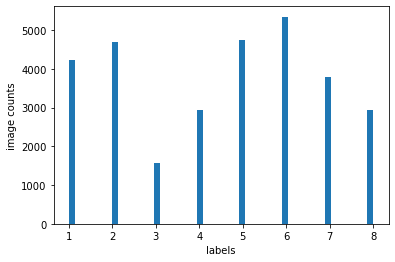

In [30]:
plt.hist(y_train, align='mid', range=(np.min(y_train), np.max(y_train)), bins=50)
plt.xlabel("labels")
plt.ylabel("image counts")
plt.show()

# KNN Classifier

In [31]:
# X_train_Stand_scaled
# X_test_Stand_scaled

# X_train_MinMax_scaled
# X_test_MinMax_scaled

### K Search:

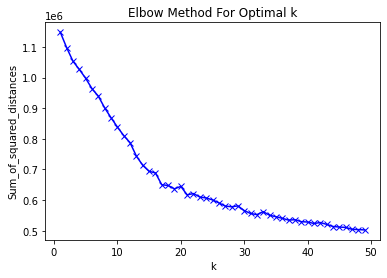

In [32]:
# Elbow using Standard Scaler
Sum_of_squared_distances = []
K = range(1,50)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X_train_Stand_scaled)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

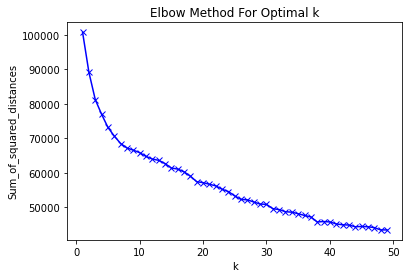

In [33]:
# Elbow using MinMax Scaler
Sum_of_squared_distances = []
K = range(1,50)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X_train_MinMax_scaled)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [34]:
# X_train_Stand_scaled
# X_test_Stand_scaled

# X_train_MinMax_scaled
# X_test_MinMax_scaled

Text(0, 0.5, 'Silhouette Score')

<Figure size 432x288 with 0 Axes>

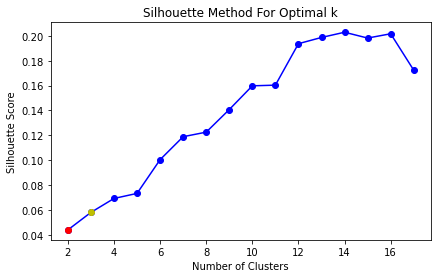

In [35]:
# Silhouette using Standard Scaler

import matplotlib.pyplot as plt
%matplotlib inline
X=X_train_Stand_scaled
# Variables to store silhouette score and inertia for different clusters
scores = []
from sklearn.metrics import silhouette_score
# Calculate silhouette scores and inertia for different number of clusters
for cluster_number in range(2,18):
  km = KMeans(n_clusters=k)
  km = KMeans(n_clusters=cluster_number, random_state=42).fit(X)
  scores.append(silhouette_score(X,km.labels_))
#plot the results
plt.clf()
plt.figure(figsize=(15,4))
#plot Silhouette Score
plt.subplot(121)
plt.plot(range(2,18), scores, 'bo-')
plt.plot(2, scores[0], 'ro-')
plt.plot(3, scores[1], 'yo-')
plt.title('Silhouette Method For Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

Text(0, 0.5, 'Silhouette Score')

<Figure size 432x288 with 0 Axes>

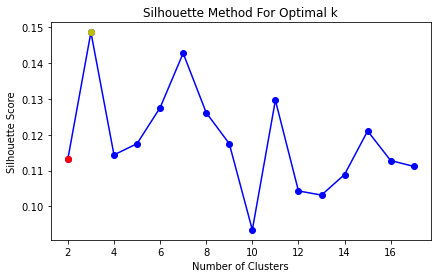

In [36]:
# Silhouette using MinMax Scaler
import matplotlib.pyplot as plt
%matplotlib inline
X=X_train_MinMax_scaled
# Variables to store silhouette score and inertia for different clusters
scores = []
from sklearn.metrics import silhouette_score
# Calculate silhouette scores and inertia for different number of clusters
for cluster_number in range(2,18):
  km = KMeans(n_clusters=k)
  km = KMeans(n_clusters=cluster_number, random_state=42).fit(X)
  scores.append(silhouette_score(X,km.labels_))
#plot the results
plt.clf()
plt.figure(figsize=(15,4))
#plot Silhouette Score
plt.subplot(121)
plt.plot(range(2,18), scores, 'bo-')
plt.plot(2, scores[0], 'ro-')
plt.plot(3, scores[1], 'yo-')
plt.title('Silhouette Method For Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

### KNN Model:

In [37]:
# X_train_Stand_scaled
# X_test_Stand_scaled

# X_train_MinMax_scaled
# X_test_MinMax_scaled

In [38]:
# import sklearn
# sklearn.metrics.SCORERS.keys()

In [41]:
# Data with Standard Scaler HERE CONTINUE
kn_Stand_Scaler = KNeighborsClassifier(n_neighbors=15)
kn_Stand_Scaler.fit(X_train_Stand_scaled, y_train)

y_pred_KNN_with_StandScaler = kn_Stand_Scaler.predict(X_test_Stand_scaled)
y_true = y_test

print("KNN result (using Standard Scaler):")
#print("    * Score is:", score(y_pred_KNN_grid_with_StandScaler, y_test)
print("Score (accuracy):", cross_val_score(kn_Stand_Scaler, X_test_Stand_scaled, y_test, cv=5, scoring='accuracy'))
print("    * Accuracy:", round(accuracy_score(y_test, y_pred_KNN_with_StandScaler)*100, 2), "%")
print("    * Precision:", round(precision_score(y_test, y_pred_KNN_with_StandScaler,
                                    average='macro')*100, 2), "%")
print("    * Recall:", round(recall_score(y_test, y_pred_KNN_with_StandScaler,
                              average='macro')*100, 2), "%")

KNN result (using Standard Scaler):
Score (accuracy): [0.25984556 0.26254826 0.25328185 0.26023166 0.26756757]
    * Accuracy: 29.89 %
    * Precision: 32.18 %
    * Recall: 26.83 %


In [48]:
pickle.dump(kn_Stand_Scaler, open("kn_Stand_Scaler_COVID.sav", 'wb'))

In [42]:
# Data with MinMax
kn_MinMax_Scaler = KNeighborsClassifier(n_neighbors=15)
kn_MinMax_Scaler.fit(X_train_MinMax_scaled, y_train)

y_pred_KNN_with_MinMaxScaler = kn_MinMax_Scaler.predict(X_test_MinMax_scaled)
y_true = y_test

print("KNN result (using MinMax Scaler):")
#print("    * Score is:", score(y_pred_KNN_with_MinMaxScaler, y_test)
print("Score (accuracy):", cross_val_score(kn_MinMax_Scaler, X_test_MinMax_scaled, y_test, cv=5, scoring='accuracy'))
print("    * Accuracy:", round(accuracy_score(y_test, y_pred_KNN_with_MinMaxScaler)*100, 2), "%")
print("    * Precision:", round(precision_score(y_test, y_pred_KNN_with_MinMaxScaler,
                                    average='macro')*100, 2), "%")
print("    * Recall:", round(recall_score(y_test, y_pred_KNN_with_MinMaxScaler,
                              average='macro')*100, 2), "%")

KNN result (using MinMax Scaler):
Score (accuracy): [0.27258687 0.27490347 0.26100386 0.26254826 0.27142857]
    * Accuracy: 28.25 %
    * Precision: 28.78 %
    * Recall: 24.97 %


In [49]:
pickle.dump(kn_MinMax_Scaler, open("kn_MinMax_Scaler_COVID.sav", 'wb'))

------------------------------------------------------------------------------------------------------------------------